In [1]:
from pandas import read_csv, DataFrame
from torch import manual_seed, Tensor
from torch.autograd import Variable
from ts_functions import split_dataframe, sliding_window
from sklearn.preprocessing import MinMaxScaler

target = 'QV2M'
index_col='date'

file_tag = 'drought'
data = read_csv('../data/forecasting/drought.forecasting_dataset.csv', index_col=index_col, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
data.drop(["PRECTOT", "PS", "T2M", "T2MDEW", "T2MWET", "TS"], axis=1, inplace=True)
data = data.sort_values('date')

nr_features = len(data.columns)
sc = MinMaxScaler()
data = DataFrame(sc.fit_transform(data), index=data.index, columns=data.columns)
manual_seed(1)
train, test = split_dataframe(data, trn_pct=.70)

In [2]:
from dslstm import DS_LSTM

seq_length = 4
num_epochs = 2000

trnX, trnY = sliding_window(train, seq_length = seq_length)
trnX, trnY  = Variable(Tensor(trnX)), Variable(Tensor(trnY))
tstX, tstY = sliding_window(test, seq_length = seq_length)
tstX, tstY  = Variable(Tensor(tstX)), Variable(Tensor(tstY))

my_lstm = DS_LSTM(input_size=1, hidden_size=8, learning_rate=0.001)

for epoch in range(num_epochs+1):
    loss = my_lstm.fit(trnX, trnY)
    if epoch % 500 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss))

Epoch: 0, loss: 0.59424
Epoch: 500, loss: 0.03968
Epoch: 1000, loss: 0.03282
Epoch: 1500, loss: 0.03037
Epoch: 2000, loss: 0.03013


In [3]:
from sklearn.metrics import r2_score

prd_trn = my_lstm(trnX)
prd_tst = my_lstm(tstX)

print('TRAIN R2=', r2_score(trnY.data.numpy(), prd_trn.data.numpy()))
print('TEST R2=', r2_score(tstY.data.numpy(), prd_tst.data.numpy()))

TRAIN R2= 0.5174741588647476
TEST R2= 0.5116707433856245


LSTM - seq length=4 hidden_units=8 and nr_episodes=500->0.39
LSTM - seq length=4 hidden_units=8 and nr_episodes=1000->0.51
LSTM - seq length=4 hidden_units=8 and nr_episodes=2500->0.52
LSTM - seq length=4 hidden_units=8 and nr_episodes=5000->0.54
LSTM - seq length=4 hidden_units=16 and nr_episodes=500->0.40
LSTM - seq length=4 hidden_units=16 and nr_episodes=1000->0.51
LSTM - seq length=4 hidden_units=16 and nr_episodes=2500->0.52
LSTM - seq length=4 hidden_units=16 and nr_episodes=5000->0.55
LSTM - seq length=4 hidden_units=32 and nr_episodes=500->0.49
LSTM - seq length=4 hidden_units=32 and nr_episodes=1000->0.51
LSTM - seq length=4 hidden_units=32 and nr_episodes=2500->0.52
LSTM - seq length=4 hidden_units=32 and nr_episodes=5000->0.54
LSTM - seq length=20 hidden_units=8 and nr_episodes=500->0.48
LSTM - seq length=20 hidden_units=8 and nr_episodes=1000->0.53
LSTM - seq length=20 hidden_units=8 and nr_episodes=2500->0.58
LSTM - seq length=20 hidden_units=8 and nr_episodes=5000->0.61


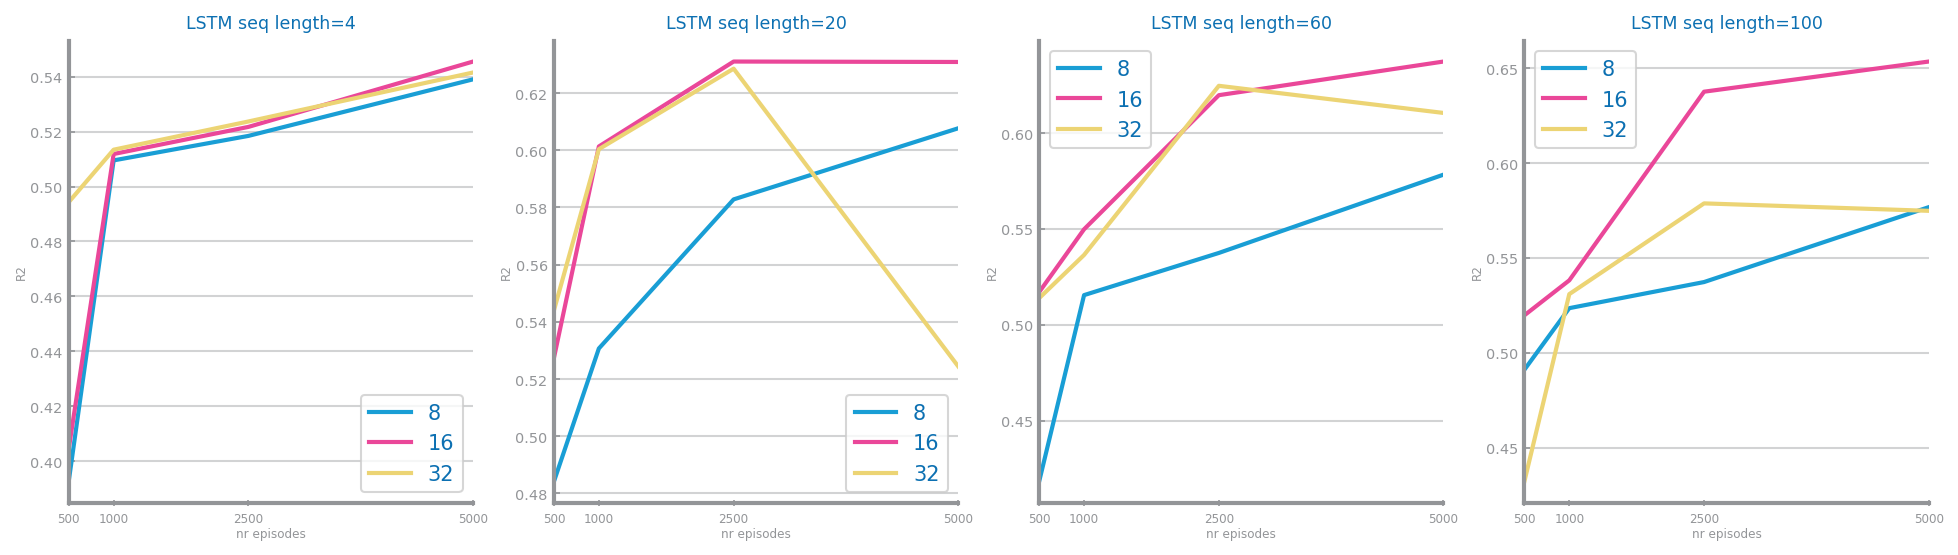

In [4]:
from torch import manual_seed, Tensor
from torch.autograd import Variable
from dslstm import DS_LSTM
from ds_charts import HEIGHT, multiple_line_chart
from matplotlib.pyplot import subplots, show, savefig
from ts_functions import PREDICTION_MEASURES, plot_evaluation_results, plot_forecasting_series, sliding_window

best = ('',  0, 0.0)
last_best = -100
best_model = None

measure = 'R2'
flag_pct = False

learning_rate = 0.001
sequence_size = [4, 20, 60, 100]
nr_hidden_units = [8, 16, 32]
max_iter = [500, 500, 1500, 2500]
episode_values = [max_iter[0]]
for el in max_iter[1:]:
    episode_values.append(episode_values[-1]+el)

nCols = len(sequence_size)
_, axs = subplots(1, nCols, figsize=(nCols*HEIGHT, HEIGHT), squeeze=False)
values = {}
for s in range(len(sequence_size)):
    length = sequence_size[s]
    trnX, trnY = sliding_window(train, seq_length = length)
    trnX, trnY  = Variable(Tensor(trnX)), Variable(Tensor(trnY))
    tstX, tstY = sliding_window(test, seq_length = length)
    tstX, tstY  = Variable(Tensor(tstX)), Variable(Tensor(tstY))

    for k in range(len(nr_hidden_units)):
        hidden_units = nr_hidden_units[k]
        yvalues = []
        model = DS_LSTM(input_size=nr_features, hidden_size=hidden_units, learning_rate=learning_rate)
        next_episode_i = 0
        for n in range(1, episode_values[-1]+1):
            model.fit(trnX, trnY)
            if n == episode_values[next_episode_i]:
                next_episode_i += 1
                prd_tst = model.predict(tstX)
                yvalues.append((PREDICTION_MEASURES[measure])(tstY, prd_tst))
                print((f'LSTM - seq length={length} hidden_units={hidden_units} and nr_episodes={n}->{yvalues[-1]:.2f}'))
                if yvalues[-1] > last_best:
                    best = (length, hidden_units, n)
                    last_best = yvalues[-1]
                    best_model = model
        values[hidden_units] = yvalues

    multiple_line_chart(
        episode_values, values, ax=axs[0, s], title=f'LSTM seq length={length}', xlabel='nr episodes', ylabel=measure, percentage=flag_pct)
print(f'Best results with seq length={best[0]} hidden={best[1]} episodes={best[2]} ==> measure={last_best:.2f}')
savefig(f'images/{file_tag}_lstm_study.png')
show()

{'RMSE': [0.13063060634391133, 0.14646073468501988], 'MAE': [0.101144604, 0.110207416]} {'R2': [0.7276353312631081, 0.6535143256993725]}


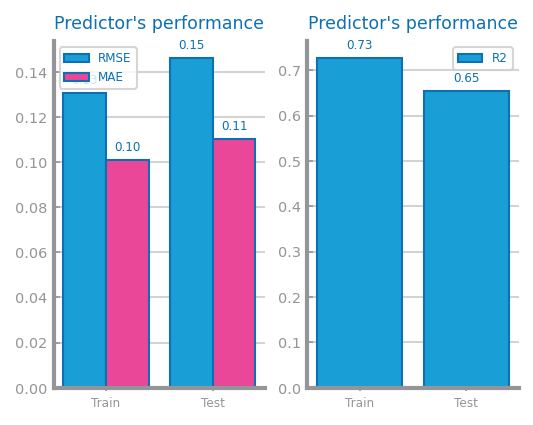

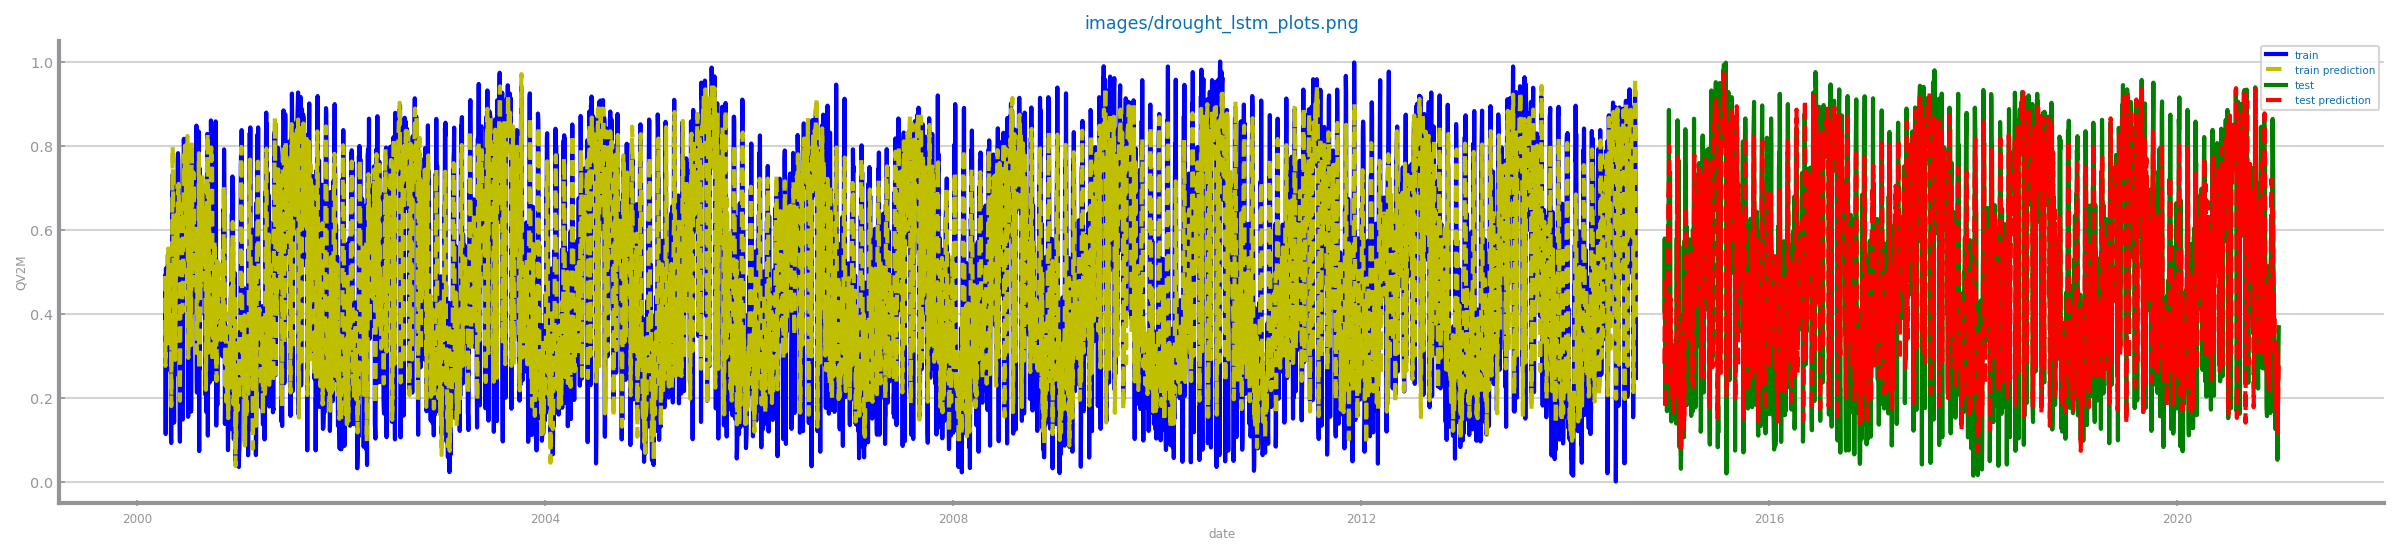

In [5]:
trnX, trnY = sliding_window(train, seq_length = best[0])
trainY = DataFrame(trnY)
trainY.index = train.index[best[0]+1:]
trainY.columns = [target]
trnX, trnY  = Variable(Tensor(trnX)), Variable(Tensor(trnY))
prd_trn = best_model.predict(trnX)
prd_trn = DataFrame(prd_trn)
prd_trn.index=train.index[best[0]+1:]
prd_trn.columns = [target]

tstX, tstY = sliding_window(test, seq_length = best[0])
testY = DataFrame(tstY)
testY.index = test.index[best[0]+1:]
testY.columns = [target]
tstX, tstY  = Variable(Tensor(tstX)), Variable(Tensor(tstY))
prd_tst = best_model.predict(tstX)
prd_tst = DataFrame(prd_tst)
prd_tst.index=test.index[best[0]+1:]
prd_tst.columns = [target]

plot_evaluation_results(trnY.data.numpy(), prd_trn, tstY.data.numpy(), prd_tst, f'images/{file_tag}_lstm_eval.png')
show()
plot_forecasting_series(trainY, testY, prd_trn.values, prd_tst.values, f'images/{file_tag}_lstm_plots.png', x_label=index_col, y_label=target)
show()